In [1]:
import sys
import pandas as pd
from importlib import reload
import numpy as np
sys.path += ["../src"]
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
from glob import glob
import warnings
from IPython.display import display, Latex
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import combinations

In [2]:
sns.set_palette([sns.color_palette("colorblind")[k] for k in [-1,4,2,3]])

In [3]:
sns.color_palette()

[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0)]

In [4]:
methods = ["svinormal", "sviNF", "mcmc", "abc"]

In [5]:
convert_to_exp = lambda l: [fr"$10^{u}$" if u >= 0 else fr"$0$" for u in l]

In [6]:
# path =  "../data/leaders_exp/est*"
path =  "../data/rewire_240422/est*"
# path =  "../data/leaders_exp2/est*"

df =  pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in glob(path)]).sort_values("method", ascending = False).assign(rep = lambda x: [u.split("_")[0] for u in x["id"]])

In [7]:
df.groupby(["q", "T"]).count()["id"].unstack()

T,128,512,2048,8192
q,,,,
0.2,80,80,80,80
0.4,80,80,80,80
0.6,80,80,80,80
0.8,80,80,80,80


In [8]:
full_id = list(df["id"].value_counts().reset_index().query("count == 4")["id"])
ids_methods = {method: list(df.query("method == @method")["id"]) for method in methods}

print("Total number of combinations", len(df.query("(method == 'abc')&(rep == '1')")))
print("Total number of experiments", len(df.query("(method == 'svinormal')&(rep == '1')")) * 3 * 4)
print("Total number of completed experiments", len(df))
print("Experiments completed with all the methods", len(full_id))

Total number of combinations 16
Total number of experiments 192
Total number of completed experiments 1280
Experiments completed with all the methods 320


In [9]:
df.columns

Index(['id', 'mse_params', 'mse_epsilon', 'tot_time', 'n_steps', 'n_samples',
       'method', 'n_simulations', 'epsilon_plus_error', 'epsilon_minus_error',
       'beta_error', 'epsilon_plus_mean', 'epsilon_minus_mean', 'beta_mean',
       'epsilon_plus_std', 'epsilon_minus_std', 'beta_std',
       'epsilon_plus_real', 'epsilon_minus_real', 'beta_real',
       'pos_interactions_plus', 'pos_interactions_minus', 'pos_rewires',
       'tot_interactions', 'q', 'T', 'N', 'edge_per_t', 'var_X_end',
       'skew_X_end', 'kurtosis_X_end', 'bimodality_X_end', 'rep'],
      dtype='object')

In [10]:
epsilons = ["epsilon_plus", "epsilon_minus"]
methods_names = ["SVI - Normal", "SVI - NF", "MCMC", "ABC"]
patches_methods = [mpatches.Patch(color = sns.color_palette()[j], label = method) for j,method in enumerate(methods_names)]
y_vars = ["rmse_epsilon", "beta"]
signs = ["plus", "minus"]

df["n_iter"] = df.fillna(0)["n_steps"] + df.fillna(0)["n_samples"]
df["rmse_epsilon"] = df["mse_epsilon"] ** (0.5)
df["rmse_params"] = df["mse_params"] ** (0.5)
df["interaction_per_person"] = df["T"] * df["edge_per_t"] / df["N"]
# df["diff_epsilon_plus"] = df["epsilon_F_plus_real"] - df["epsilon_L_plus_real"]
# df["diff_epsilon_minus"] = -(df["epsilon_F_minus_real"] - df["epsilon_L_minus_real"])
# df["error_roles"] = 1 - df["accuracy_roles"]
df["pos_interactions"] = df["pos_interactions_plus"] + df["pos_interactions_minus"]
# df["pos_interactions_L"] = df["pos_interactions_L_plus"] + df["pos_interactions_L_minus"]
# df["proportion_leaders"] = 1 / df["initial_leaders_ratio"]

# for eps in epsilons:
#     df[eps + "_in_bound"] = ((df[eps + "_real"] - 2 * df[eps + "_std"]) < df[eps + "_mean"]) & (df[eps + "_mean"] < (df[eps + "_real"] + 2 * df[eps + "_std"]))


In [11]:
vars = {type_var: [u for u in df.columns if type_var in u] for type_var in ["std", "error", "mean", "real", "X", "interaction"]}
vars["error"]

['epsilon_plus_error', 'epsilon_minus_error', 'beta_error']

In [12]:
dfs = {method: df.query("method == @method").reset_index().drop("index", axis = 1) for method in methods}

### Paper plots

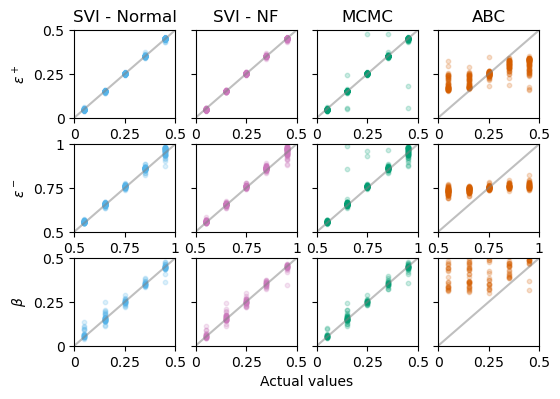

In [13]:
fig, axes = sbp(ncols = 4, nrows = 3, figsize = (6, 4.1), sharey = "row")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.3)

xs = vars["real"]
ys = vars["mean"]
ax_lims = [(0,0.5), (0.5,1.), (0,0.5)]
ax_ticks = [(0,0.25,0.5), (0.5,0.75,1), (0, 0.25, 0.5)]
for i, var_str in enumerate([r"$\epsilon^+$", r"$\epsilon^-$", r"$\beta$"]):
    for j,method in enumerate(methods):
        axes[i,j].plot(ax_lims[i], ax_lims[i], color = "grey", alpha = 0.5)
        sns.regplot(dfs[method], x = xs[i], y = ys[i], ax = axes[i,j], color = sns.color_palette()[j],fit_reg = False, x_jitter = 0.0, scatter_kws = {"alpha": 0.2, "s": 10})
        axes[i,j].set_xlim(ax_lims[i])
        axes[i,j].set_ylim(ax_lims[i])
            
        axes[0,j].set_title(["SVI - Normal", "SVI - NF", "MCMC", "ABC"][j])
        # axes[i,j].set_xlabel(r"Real $\epsilon$" +  var_str)
        axes[i,j].set_xlabel("")
        axes[i,j].set_ylabel("")
        axes[i,j].set_xticks(ax_ticks[i], [str(u) for u in ax_ticks[i]])
        axes[i,j].set_yticks(ax_ticks[i], [str(u) for u in ax_ticks[i]])
        # axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # axes[i,0].set_ylabel(r"Estimated $\epsilon$" + var_str)
    axes[i,0].set_ylabel(var_str)
           
axes[1,0].legend(loc='upper center', bbox_to_anchor=(2.3, -0.43), fancybox=True, ncol=4, handles = patches_methods)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Actual values")

# fig.savefig(f"../paper/scatterplot_extended_bottomlegend.pdf", bbox_inches="tight")

axes[1,0].get_legend().remove()
# fig.savefig(f"../paper/scatterplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()


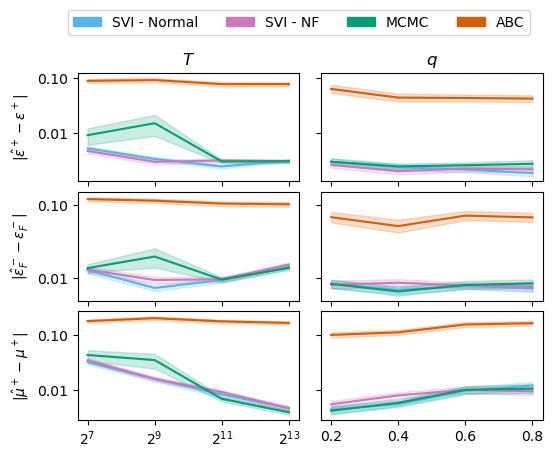

In [13]:
fig, axes = sbp(ncols = 2, nrows = 3, figsize = (6,4.5), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.1, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
x_lab_beta=[0.2, 0.4, 0.6, 0.8]


for i, y_var in enumerate(['epsilon_plus_error', 'epsilon_minus_error', 'beta_error']):
    for j, x_var in enumerate(["T", "q"]):
        # for method in methods:
            # sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[i,j], errorbar = "se")
        # sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se", palette = colors)
        sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se")
        axes[0,j].set_title([r"$T$", r"$q$"][j])
        axes[i,j].set_yscale("log")
        # axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_xscale("log")

        axes[i,j].tick_params(axis = u'both', which = 'minor', length=0)
        axes[i,j].xaxis.set_minor_locator(plt.NullLocator())
        axes[i,j].set_xlabel("")
        axes[i,j].set_xticks([x_lab_T, x_lab_beta][j], 
                             [x_labT_pow2, x_lab_beta][j])
        axes[i,j].get_legend().remove()
        if j < 4:   
            axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if j == 2:
            axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
    axes[i,0].set_ylabel([r"$| \hat{\epsilon}^+ - \epsilon^+ |$", r"$| \hat{\epsilon}^-_F - \epsilon^-_F |$",
                          r"$| \hat{\mu}^+ - \mu^+ |$", r"$| \hat{\mu}^-_F - \mu^-_F |$",][i])
    axes[i,1].set_ylabel("")
    
        
axes[2,0].legend(loc='upper center', bbox_to_anchor=(1., -0.2), fancybox=True, ncol=4, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/lineplot_extended_bottomlegend.pdf", bbox_inches="tight")

axes[2,0].get_legend().remove()
axes[0,0].legend(loc='upper center', bbox_to_anchor=(1., 1.65), fancybox=True, ncol=4, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/lineplot_extended_toplegend.pdf", bbox_inches="tight")

# axes[0,0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_extended_nolegend.pdf", bbox_inches="tight")
# fig.show()

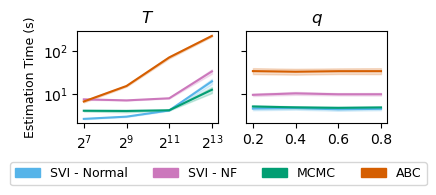

In [15]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (4,1.2), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
x_lab_q=[0.2, 0.4, 0.6, 0.8]

y_var = "tot_time"
for j, x_var in enumerate(["T", "q"]):
    # for method in methods:
    #     sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[j], errorbar = "se")
    sns.lineplot(data = df, x = x_var, y = y_var, ax = axes[j], hue = "method", errorbar = "se")
    axes[j].set_title([r"$T$",r"$q$"][j])
    if j == 0:
        axes[j].set_xscale("log")
    axes[j].set_yscale("log")

    axes[j].tick_params(axis = u'both', which = 'minor', length=0)
    axes[j].xaxis.set_minor_locator(plt.NullLocator())
    axes[j].set_xlabel("")
    axes[j].set_xticks([x_lab_T, x_lab_q][j], 
                       [x_labT_pow2, x_lab_q][j])
    axes[j].get_legend().remove()
    
        
axes[0].set_ylabel("Estimation Time (s)", fontsize = 9)
axes[1].set_ylabel("")

axes[1].legend(loc='upper center', bbox_to_anchor=(1.8, 1.1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 12)
# fig.savefig(f"../paper/lineplot_estimation_time_rightlegend.pdf", bbox_inches="tight")

axes[1].get_legend().remove()
axes[0].legend(loc='upper center', bbox_to_anchor=(1, -0.35), fancybox=True, ncol=4, handles = patches_methods, fontsize = 9)
# fig.savefig(f"../paper/lineplot_estimation_time_bottomlegend.pdf", bbox_inches="tight")

# axes[0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_estimation_time_nolegend.pdf", bbox_inches="tight")
# fig.show()

In [42]:
df.columns

Index(['id', 'mse_params', 'mse_epsilon', 'mse_mu', 'tot_time', 'n_steps',
       'n_samples', 'method', 'n_simulations', 'epsilon_plus_error',
       'epsilon_minus_error', 'mu_plus_error', 'mu_minus_error',
       'epsilon_plus_mean', 'epsilon_minus_mean', 'mu_plus_mean',
       'mu_minus_mean', 'epsilon_plus_std', 'epsilon_minus_std', 'mu_plus_std',
       'mu_minus_std', 'epsilon_plus_real', 'epsilon_minus_real',
       'mu_plus_real', 'mu_minus_real', 'pos_interactions_plus',
       'pos_interactions_minus', 'tot_interactions', 'T', 'N', 'edge_per_t',
       'var_X_end', 'skew_X_end', 'kurtosis_X_end', 'bimodality_X_end', 'rep',
       'n_iter', 'rmse_epsilon', 'rmse_mu', 'interaction_per_person',
       'pos_interactions'],
      dtype='object')

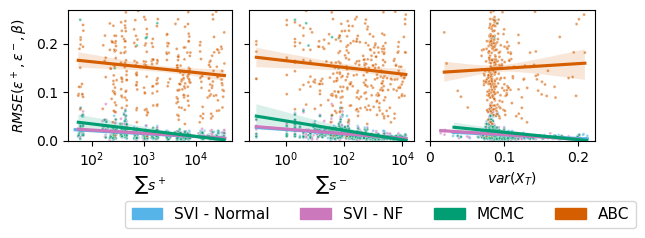

In [16]:
fig, axes = sbp(ncols = 3, nrows = 1, figsize = (6.8,1.7), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.1, hspace = 0.)

x_vars = ['pos_interactions_plus', 'pos_interactions_minus', "var_X_end"]
y_var = "rmse_params"
# y_var = "rel_error_f"

# x_ticks_exp = [[10**3,10**4,10**5], [10**3,10**4,10**5], [0,0.1,0.2]]
x_ticks_exp = [[2,3,4], [0,2,4], [0,0.1,0.2]]
# y_ticks_exp = [-1, -2]
y_lim = [0, 0.27]
for j, x_var in enumerate(x_vars):
    sns.scatterplot(data = df.assign(
            rmse_epsilon = lambda x:np.log10(x["rmse_epsilon"] + 0.0001),
            pos_interactions_plus = lambda x:np.log10(x["pos_interactions_plus"] + 0.1),
            pos_interactions_minus = lambda x:np.log10(x["pos_interactions_minus"] + 0.1),
            ),
            x = x_var, y = y_var, ax = axes[j], marker = ".", size = 0.05, alpha = 0.6, hue = "method")
    for k,method in enumerate(methods):
        sns.regplot(data = df.assign(
            pos_interactions_plus = lambda x:np.log10(x["pos_interactions_plus"] + 0.1),
            pos_interactions_minus = lambda x:np.log10(x["pos_interactions_minus"] + 0.1),
            rmse_epsilon = lambda x:np.log10(x["rmse_epsilon"] + 0.)).query("method == @method"),
            x = x_var, y = y_var, ax = axes[j], color = sns.color_palette()[k], scatter_kws = {'s': 0})
    axes[j].set_xticks(x_ticks_exp[j], convert_to_exp(x_ticks_exp[j]) if j < 2 else x_ticks_exp[j])
    
    # axes[j].set_yticks(y_ticks_exp, [r"$10^{-1}$", r"$10^{-2}$"])
    axes[j].set_ylabel("")
    axes[j].set_xlabel("")
    axes[j].set_ylim(y_lim)
    axes[j].set_xlabel([r"$\sum s^+$", r"$\sum s^-$", r"$var(X_T)$"][j])
    axes[0].set_ylabel(r"$RMSE(\epsilon^+, \epsilon^-, \beta)$")
    # axes[0].set_ylabel(r"$RMSE(\hat{\epsilon}^+_F, \hat{\epsilon}^-_F, \hat{\epsilon}^+_L, \hat{\epsilon}^-_L)$")
    axes[j].get_legend().remove()
    
axes[2].legend(loc='upper center', bbox_to_anchor=(1.5, 1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/regplot_rmse_rightlegend.pdf", bbox_inches="tight")

axes[2].get_legend().remove()
axes[0].legend(loc='upper center', bbox_to_anchor=(1.9, -0.4), fancybox=True, ncol=4, handles = patches_methods, fontsize = 11)
# fig.savefig(f"../paper/regplot_rmse_bottomlegend.pdf", bbox_inches="tight")

# axes[0].get_legend().remove()
# fig.savefig(f"../paper/regplot_rmse_nolegend.pdf", bbox_inches="tight")
# fig.show()

### Quantitative Results

In [18]:
for method in methods:
    print(f"Average RMSE epsilon {method} {df.query('(method == @method)')['rmse_epsilon'].mean()}")

print("")
for method in methods:
    print(f"Average RMSE parameters {method} {df.query('(method == @method)')['rmse_params'].mean()}")

print("")

for method in methods:
    print(f"Average RMSE intersection {method} {df.query('(method == @method)&(id in @full_id)')['rmse_epsilon'].mean()}")

print("")

print("")
method = "sviNF"
print(f"Average RMSE parameters with filter A {df.query('(method == @method)&(pos_interactions > 10)')['rmse_params'].mean()}")
print(f"Average RMSE parameters with filter B {df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['rmse_params'].mean()}")
print("")
for method in methods:
    print(f"Average estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean()}")
print("")
method0 = "svinormal"
for method in methods:
    print(f"Average estimation time vs svinormal estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean() / df.query('(id in @full_id)&(method == @method0)')['tot_time'].mean()}")
print("")
method0 = "sviNF"
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(f"Average RMSE params vs svinNF RMSE {method} {df.query('(id in @id_inters)&(method == @method)')['rmse_params'].mean() / df.query('(id in @id_inters)&(method == @method0)')['rmse_params'].mean()}")
print("")
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(f"Average improvement RMSE params vs svinNF RMSE {method} {1 - df.query('(id in @id_inters)&(method == @method0)')['rmse_params'].mean() / df.query('(id in @id_inters)&(method == @method)')['rmse_params'].mean()}")
print("")
print(f"Average time biggest experiments {df.query('(T == 8192)')['tot_time'].mean()}")



Average RMSE epsilon svinormal 0.008591623591054906
Average RMSE epsilon sviNF 0.009207202734220404
Average RMSE epsilon mcmc 0.012658704157815438
Average RMSE epsilon abc 0.10939404407033462

Average RMSE parameters svinormal 0.012923386114365295
Average RMSE parameters sviNF 0.013711180395233932
Average RMSE parameters mcmc 0.01872863128421194
Average RMSE parameters abc 0.14892125317508045

Average RMSE intersection svinormal 0.008591623591054906
Average RMSE intersection sviNF 0.009207202734220404
Average RMSE intersection mcmc 0.012658704157815438
Average RMSE intersection abc 0.10939404407033462


Average RMSE parameters with filter A 0.013711180395233932
Average RMSE parameters with filter B 0.007863066550374043

Average estimation time svinormal 7.249932421743869
Average estimation time sviNF 13.81018661260605
Average estimation time mcmc 6.118992169201374
Average estimation time abc 78.05544830486178

Average estimation time vs svinormal estimation time svinormal 1.0
Average e

### Latex Macros

In [22]:
print("\sviNFvsABCRMSE", 1 - df.query('(id in @id_inters)&(method == "sviNF")')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == "abc")')['rmse_epsilon'].mean())  
print("\sviNFvsMCMCRMSE", 1 - df.query('(id in @id_inters)&(method == "sviNF")')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == "mcmc")')['rmse_epsilon'].mean())

print("\svinormvssviNFtime", df.query('(id in @full_id)&(method == "sviNF")')['tot_time'].mean() / df.query('(id in @full_id)&(method == "svinormal")')['tot_time'].mean())
print("\svinormvsMCMCtime",  df.query('(id in @full_id)&(method == "mcmc")')['tot_time'].mean() / df.query('(id in @full_id)&(method == "svinormal")')['tot_time'].mean())
print("\svinormvsABCtime", df.query('(id in @full_id)&(method == "abc")')['tot_time'].mean() / df.query('(id in @full_id)&(method == "svinormal")')['tot_time'].mean())

print("\maxtimesvinorm", df.query('(N == 400)&(T == 8192)')['tot_time'].mean())

print("\ABCthreshold", r"$\ensuremath{5\sqrt{T}}$")
print(r"\npopulations", 1000)
print(r"\nsteps", 800)
print(r"\nsimulations", 5000)
print(r"\nexperiments", 912)
print("\svinormAvgErrorRoles", df.query('(method == "svinormal")')['error_roles'].mean())
print("\sviNFAvgErrorRoles", df.query('(method == "sviNF")')['error_roles'].mean())
print("\mcmcAvgErrorRoles", df.query('(method == "mcmc")')['error_roles'].mean())
print(r"\abcAvgErrorRoles", df.query('(method == "abc")')['error_roles'].mean())
print("\svinormAvgRMSE", df.query('(method == "svinormal")')['rmse_epsilon'].mean())
print("\sviNFAvgRMSE", df.query('(method == "sviNF")')['rmse_epsilon'].mean())
print("\mcmcAvgRMSE", df.query('(method == "mcmc")')['rmse_epsilon'].mean())
print(r"\abcAvgRMSE", df.query('(method == "abc")')['rmse_epsilon'].mean())
print(r"\timeout", "3 hours")


print("\sviNFAvgErrorRolesFilterA", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)')['error_roles'].mean())
print("\sviNFAvgErrorRolesFilterB", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(var_X_end > 0.1)&(pos_interactions_L > 10)')['error_roles'].mean())
print("\sviNFAvgRMSEFilterA", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)')['rmse_epsilon'].mean())
print("\sviNFAvgRMSEFilterB", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(var_X_end > 0.1)&(pos_interactions_L > 10)')['rmse_epsilon'].mean())


\sviNFvsABCRMSE 0.6575377879175948
\sviNFvsMCMCRMSE 0.04490853845664555
\svinormvssviNFtime 56.04911821438542
\svinormvsMCMCtime 36.92359122703816
\svinormvsABCtime 36.535604073416685
\maxtimesvinorm 60.97735333442688
\ABCthreshold $\ensuremath{5\sqrt{T}}$
\npopulations 1000
\nsteps 800
\nsimulations 5000
\nexperiments 912
\svinormAvgErrorRoles 0.09438597816124297
\sviNFAvgErrorRoles 0.06255953386425972
\mcmcAvgErrorRoles 0.22356726255333215
\abcAvgErrorRoles 0.4702844462708799
\svinormAvgRMSE 0.04383746989069376
\sviNFAvgRMSE 0.03602131412102015
\mcmcAvgRMSE 0.051746219055180516
\abcAvgRMSE 0.12507523972478346
\timeout 3 hours
\sviNFAvgErrorRolesFilterA 0.02866667111714681
\sviNFAvgErrorRolesFilterB 0.018076925323559687
\sviNFAvgRMSEFilterA 0.028462416466234017
\sviNFAvgRMSEFilterB 0.02918460840196332


In [18]:
df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(var_X_end > 0.1)').sort_values(['error_roles'], ascending = False)[['id', 'accuracy_roles', 'correct_leaders',
       'correct_followers',  
       'epsilon_F_minus_real', 'epsilon_L_minus_real',
       'pos_interactions_L_plus', 'pos_interactions_L_minus',
       'pos_interactions_F_plus', 'pos_interactions_F_minus',
       'tot_interactions_L', 'tot_interactions_F', 'T', 'N', 'edge_per_t',
       'initial_leaders', 'initial_leaders_ratio', 'var_X_end', 'skew_X_end',
       'kurtosis_X_end', 'bimodality_X_end', 'rep', 'n_iter', 'rmse_epsilon',
       'interaction_per_person', 'diff_epsilon_plus', 'diff_epsilon_minus',
       'error_roles']]

,id,accuracy_roles,correct_leaders,correct_followers,epsilon_F_minus_real,epsilon_L_minus_real,pos_interactions_L_plus,pos_interactions_L_minus,pos_interactions_F_plus,pos_interactions_F_minus,...,skew_X_end,kurtosis_X_end,bimodality_X_end,rep,n_iter,rmse_epsilon,interaction_per_person,diff_epsilon_plus,diff_epsilon_minus,error_roles
0,1_50_50_128,0.92,1.0,0.918367,0.55,0.65,6,5,686,340,...,0.658099,-1.034838,0.086772,1,10000,0.099631,25.6,0.2,0.1,0.08
0,0_50_10_8192,0.92,0.2,1.000000,0.65,0.75,2345,2219,25212,16376,...,0.435400,-1.343141,0.137105,0,10000,0.100535,1638.4,0.1,0.1,0.08
0,1_50_25_128,0.96,1.0,0.958333,0.55,0.65,8,9,478,345,...,0.274835,-1.386672,0.068639,1,10000,0.012048,25.6,0.1,0.1,0.04
0,1_50_50_512,0.96,1.0,0.959184,0.55,0.85,43,33,1794,1871,...,0.547743,-1.620529,0.169998,1,10000,0.038163,102.4,0.1,0.3,0.04
0,0_100_100_512,0.97,1.0,0.969697,0.55,0.85,6,5,1330,1446,...,0.105575,-1.617505,0.103985,0,10000,0.040072,51.2,0.1,0.3,0.03
0,1_100_10_512,0.97,1.0,0.966667,0.75,0.85,139,2,1938,333,...,0.161197,-1.179086,0.047201,1,10000,0.010393,51.2,0.1,0.1,0.03
0,1_50_5_128,0.98,1.0,0.975000,0.55,0.85,21,4,272,307,...,0.129529,-1.468042,0.092635,1,10000,0.005089,25.6,0.1,0.3,0.02
0,0_50_10_512,0.98,1.0,0.977778,0.55,0.85,92,90,1433,1613,...,0.447233,-1.652886,0.169998,0,10000,0.007546,102.4,0.1,0.3,0.02
0,1_50_10_512,1.00,1.0,1.000000,0.55,0.95,145,29,2518,1912,...,-0.401110,-1.780182,0.187948,1,10000,0.010332,102.4,0.3,0.4,0.00
0,0_50_10_2048,1.00,1.0,1.000000,0.65,0.95,873,32,10585,5787,...,0.549609,-1.665321,0.179998,0,10000,0.016636,409.6,0.2,0.3,0.00


### Presentation 

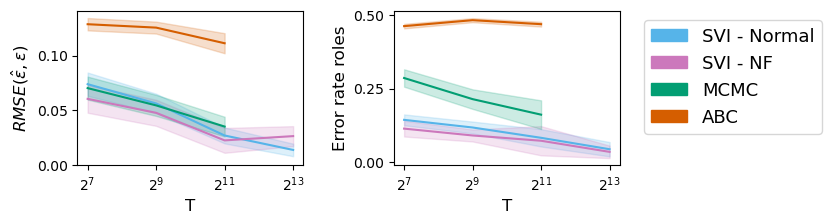

In [19]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (7,2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.4, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
# x_lab_N=[50, 100, 200, 400]
# x_lab_initial_leaders_ratio = [0.01, 0.02, 0.04, 0.1, 0.2]

x_var = "T"
for j, y_var in enumerate(["rmse_epsilon", "error_roles"]):
    sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[j], errorbar = "se")
    axes[j].set_ylabel([r"$RMSE(\hat{\varepsilon}, \varepsilon)$", r"Error rate roles"][j], fontsize = 12)
    axes[j].set_xlabel(r"T", fontsize = 12)
    axes[j].set_xscale("log")

    axes[j].tick_params(axis = u'both', which = 'minor', length=0)
    axes[j].xaxis.set_minor_locator(plt.NullLocator())
    # axes[j].set_xlabel("")
    axes[j].set_xticks(x_lab_T, x_labT_pow2)
    axes[j].get_legend().remove()
    axes[j].set_yticks([[0,0.05,0.10], [0, 0.25,0.5]][j])
    axes[j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # if j == 2:
    #     axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
    # axes[0].set_ylabel([r"RMSE $(| \hat{\varepsilon}, \varepsilon)$", "Error rate roles"][j])
    # axes[j].set_ylabel("")
    
        
axes[1].legend(loc='upper center', bbox_to_anchor=(1.5, 1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/lineplot_extended_bottomlegend.pdf", bbox_inches="tight")

# axes[4,0].get_legend().remove()
# axes[0,0].legend(loc='upper center', bbox_to_anchor=(1.45, 1.8), fancybox=True, ncol=4, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/lineplot_extended_toplegend.pdf", bbox_inches="tight")

# axes[0,0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()

In [24]:
df.query("(method == 'sviNF')&(N == 50)&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(T > 511)").mean(numeric_only = True)["accuracy_roles"]

1.0